In [4]:
from pycocotools.coco import COCO
import torch
from PIL import Image
from torchvision import tv_tensors
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from datastorage.cocodataset import COCODataset
from transformers import AutoImageProcessor
import importlib
from transformers import( Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor)
from transformers.models.mask2former.configuration_mask2former import Mask2FormerConfig
import pytorch_lightning 
import evaluate
from models.mask2former import Mask2FormerFinetuner
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

from torchmetrics.detection.mean_ap import MeanAveragePrecision

/home/ida01/tglobisch/micromamba/envs/benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ida01/tglobisch/micromamba/envs/benchmark/lib/python3.10/site-packages/lightning/fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [5]:
Config = {"do_normalize": True,
  "do_rescale": True,
  "do_resize": True,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "Mask2FormerImageProcessor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "num_labels": 150,
  "reduce_labels": False,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 1080,
    "width": 1920
  },
  "size_divisor": 32
         }

processor = Mask2FormerImageProcessor(**Config, return_tensors="pt")

In [6]:
id2label = id2label = {0: 'Unknown Instance',
 1: 'Scissors',
 2: 'Plastic Cup',
 3: 'Metal Rod',
 4: 'Fork',
 5: 'Bottle',
 6: 'Soda Can',
 7: 'Case',
 8: 'Plastic Bag',
 9: 'Cup',
 10: 'Goggles',
 11: 'Flipper',
 12: 'LoCo',
 13: 'Aqua',
 14: 'Pipe',
 15: 'Snorkel',
 16: 'Spoon',
 17: 'Lure',
 18: 'Screwdriver',
 19: 'Car',
 20: 'Tripod',
 21: 'ROV',
 22: 'Knife',
 23: 'Dive Weight',
24: 'Background'}

num_classes = len(id2label.keys())

label2id = {v:k for k,v in 
            id2label.items()}


In [7]:
 def collate_fn(batch):
    inputs = list(zip(*batch))        
    images=inputs[0]
    segmentation_maps=inputs[1]
    batch = processor(
        images,
        segmentation_maps=list(segmentation_maps),
        size=(272, 490),
        return_tensors="pt",
        ignore_index = -1 )
    batch["original_images"] = images
    batch["original_segmentation_maps"] = segmentation_maps
    return batch

In [36]:
test_data = COCODataset("/mnt/scratch/tglobisch/datasets/cou/cou/coco/coco/","test_annotations.json","images/",id2label)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True,collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Fill background with id 24


In [20]:
testmodel = Mask2FormerFinetuner.load_from_checkpoint("/home/ida01/tglobisch/checkpoints/cou/snowy-flower-326/epoch=43-step=2508.ckpt")

/home/ida01/tglobisch/micromamba/envs/benchmark/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([26]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([26, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([26]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Freezing encoder


In [21]:
metric = MeanAveragePrecision(iou_type='segm',class_metrics=True)

In [ ]:
metric.reset()
size=(272, 490)
with torch.no_grad():
    testmodel.eval()
    for batch in tqdm(test_dataloader):
        output = testmodel.model(pixel_values=batch["pixel_values"].cuda())
        target_mask =  batch["original_segmentation_maps"]
        sizes = [i.shape for i in target_mask]
       
        res = processor.post_process_semantic_segmentation(output,target_sizes=sizes)
        result = torch.stack(res).cpu()   
       
        ignore_idx = 24
        ground_truth = list()
        for mask in target_mask:
            labels = []
            masks = []
            for label in np.unique(mask):
                if label == ignore_idx:
                    continue
                labels.append(label)
                res_msk = np.zeros(mask.shape)
                res_msk[mask==label] = 1
                masks.append(res_msk)
            ground_truth.append(
                dict(
                    masks=torch.tensor(np.stack(masks)).to(torch.bool),
                    scores=torch.ones(len(masks)),
                    labels = torch.tensor(labels).long()
                )
            )
        
        preds = list()
        for mask in result:
            labels = []
            masks = []
            for label in np.unique(mask):
                if label == ignore_idx:
                    continue
                labels.append(label)
                res_msk = np.zeros(mask.shape)
                res_msk[mask==label] = 1
                masks.append(res_msk)
            if masks:
                preds.append(
                    dict(
                        masks=torch.tensor(np.stack(masks)).to(torch.bool),
                        scores=torch.ones(len(masks)),
                        labels = torch.tensor(labels).long()
                    )
                )
            else: 
                preds.append(
                    dict(
                        masks=torch.zeros((0, target_mask[0].shape[-2], target_mask[0].shape[-1]), dtype=torch.bool) ,
                        scores=torch.ones(len(masks)),
                        labels = torch.tensor(labels).long()
                    )
                )
        metric.update(preds,ground_truth)        
metric.compute()





 58%|██████████████████████████████████████████████▋                                 | 14/24 [01:06<00:46,  4.61s/it]

In [17]:
img, target = test_data.__getitem__(3)

In [18]:
img.shape

(3, 1080, 1920)

In [19]:
target.shape

(1080, 1920)

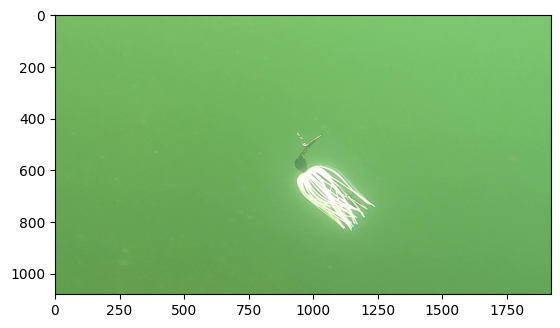

In [20]:
plt.imshow(np.einsum('chw -> hwc', img))

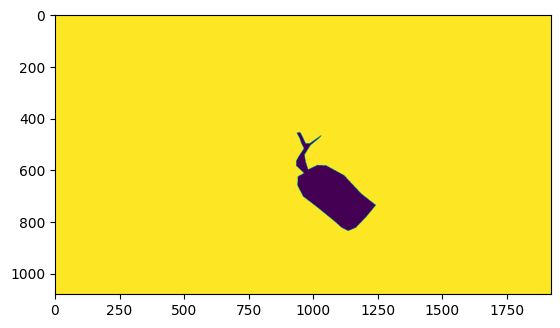

In [21]:
plt.imshow(target)

In [22]:
np.unique(target)

array([17., 24.])

In [34]:
test = processor(
        img,
        segmentation_maps=target,
        size=(272, 490),
        return_tensors="pt",
        ignore_index = -1,
        instance_id_to_semantic_id = {24:1,17:3})

In [24]:
for i in test:
    print(i)

pixel_values
pixel_mask
mask_labels
class_labels


In [35]:
test["class_labels"]

[tensor([3, 1])]

In [33]:
torch.zeros((0,288,512))

tensor([], size=(0, 288, 512))

In [38]:
testbatch = next(iter(test_dataloader))

In [42]:
testbatch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels', 'original_images', 'original_segmentation_maps'])

In [ ]:
test

In [88]:
model1 = Mask2FormerFinetuner.load_from_checkpoint("/home/ida01/tglobisch/checkpoints/cou/snowy-flower-326/epoch=43-step=2508.ckpt")

/home/ida01/tglobisch/micromamba/envs/benchmark/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([26]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([26, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([26]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and in

Freezing encoder


In [89]:

with torch.no_grad():
    model1.eval()
    output = model1.model(pixel_values=testbatch.pixel_values.cuda())

In [52]:
for i in output:
    print(i)

class_queries_logits
masks_queries_logits
encoder_last_hidden_state
pixel_decoder_last_hidden_state
transformer_decoder_last_hidden_state


In [90]:
output.class_queries_logits.shape

torch.Size([1, 100, 26])

In [91]:
for i in output.class_queries_logits[0]:
    print(np.argmax(i.cpu()))

tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(17)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(24)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)
tensor(25)

In [92]:
target_mask =  testbatch["original_segmentation_maps"]
sizes = [i.shape for i in target_mask]

In [93]:
res = processor.post_process_semantic_segmentation(output,target_sizes=sizes)

In [70]:
len(testbatch.original_segmentation_maps[0])

1080

In [75]:
sizes

[(1080, 1920)]

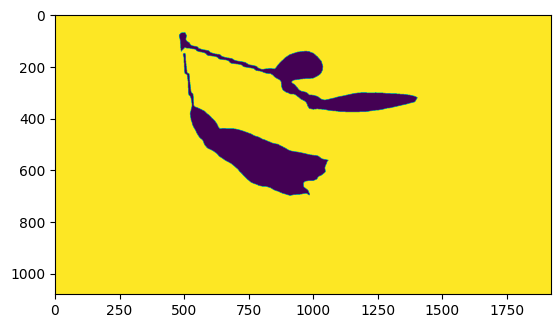

In [94]:
plt.imshow(res[0].cpu()) 

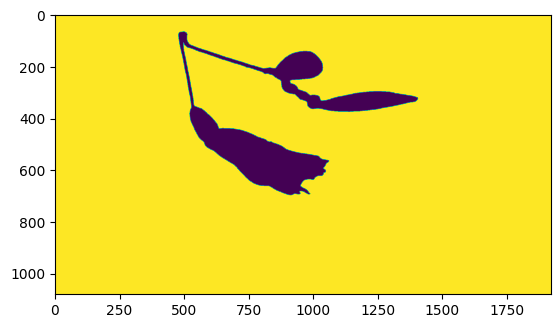

In [95]:
plt.imshow(testbatch.original_segmentation_maps[0])